In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
# check the current path
print(os.getcwd()) # /content

# You should copy the path : 왼쪽 폴더에서 오른쪽 버튼 후 경로복사
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW')

print(os.getcwd()) # path has been changed

/content
/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW


## 1.라이브러리 설치

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install retinaface-pytorch

INFO: pip is looking at multiple versions of retinaface-pytorch to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.1 MB/s eta 0:00:00
  Created wheel for jpeg4py: filename=jpeg4py-0.1.4-py3-none-any.whl size=8422 sha256=6b85c293a274ed1fa89a1cf090f15a788cf41a90d7312f70aeeb27f0bfd59d7f
  Stored in directory: /root/.cache/pip/wheels/86/c3/0f/348e6cadb3a27435e833d21d91707d653fb159d69f2a867a36
Successfully built jpeg4py


In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f20fea4c94b3c47f72261d6f503b336d1462164b1be4effcf2a75ebb91ceb6cc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
!pip install albumentations

In [ ]:
!pip install timm

## 2. 데이터셋 준비

metafile.json을 Pandas DataFrame으로 읽기

In [ ]:
import json
import pandas as pd

json_file = '/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW/train_sample_videos/metadata.json'
df = pd.read_json(json_file)
df = df.T

df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [ ]:
df.loc['aagfhgtpmv.mp4'].label

'FAKE'

In [ ]:
import cv2
from torch.utils.data import Dataset, DataLoader
from retinaface.pre_trained_models import get_model as get_retinaface_model
import albumentations as A
from torchvision.transforms import ToTensor

# RetinaFace 모델 로드
retinaface_model = get_retinaface_model("resnet50_2020-07-20", max_size=224)
retinaface_model.eval()

# 사용자 데이터셋 경로
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW/train_sample_videos'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW/test_videos'

class RetinaFacePreprocess:
    def __call__(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = retinaface_model.predict_jsons(image) # Retinaface detection
        if faces:
            try:
                x1, y1, x2, y2 = faces[0]["bbox"] # get bounding box corner coordinates
                image = image[int(y1):int(y2), int(x1):int(x2)] # crop a face image from the image
            except ValueError:
                pass
        return cv2.resize(image, (224, 224)) # resize the face image ---> 몇 개의 추출 얼굴에 대해서 확인 필요

# Albumentations 전용 변환 설정 ---> 실제 몇 개의 얼굴에 대해서 확인해 보고 유효할지 판단 필요
albumentations_transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
albumentations_transform_val = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

class VideoFrameDataset(Dataset):
    def __init__(self, video_dir, preprocess, albumentations_transform=None):
        self.video_dir = video_dir
        self.preprocess = preprocess
        self.albumentations_transform = albumentations_transform
        self.to_tensor = ToTensor()
        self.video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_files[idx])

#        print(self.video_files[idx])
        label_name = df.loc[self.video_files[idx]].label
        if label_name == 'FAKE':
            label = 1
        else:
            label = 0

        # 비디오에서 첫 번째 프레임 추출 ?
        cap = cv2.VideoCapture(video_path)
        success, frame = cap.read()
        cap.release()

        if not success:
            print(f"Warning: Could not read video file {video_path}. Skipping.")
            return self.__getitem__((idx + 1) % len(self))  # 다음 파일로 넘어감

        frame = self.preprocess(frame) # extract faces by Retianface, 현재는 모든 프레임에 대해서... 10프레임에 1개?
        if self.albumentations_transform:
            frame = self.albumentations_transform(image=frame)['image']

        frame = self.to_tensor(frame)
#        label = idx % 2  # 임시 라벨 설정 (예: 2개 클래스인 경우) ?

#        print(label)

        return frame, label

train_dataset = VideoFrameDataset(train_dir, preprocess=RetinaFacePreprocess(), albumentations_transform=albumentations_transform_train)
#val_dataset = VideoFrameDataset(test_dir, preprocess=RetinaFacePreprocess(), albumentations_transform=albumentations_transform_val)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_r

1. Ratinaface 결과를 몇개의 이미지에 대해서 imshow로 확인할 것
2. alnumentation 결과도 확인해 imshow로 볼 것
3. label이 (datasieze, 2)인지 확인할

## 3. 데이터로더 준비

torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.Size([2, 3, 224, 224])
torch.Size([2])


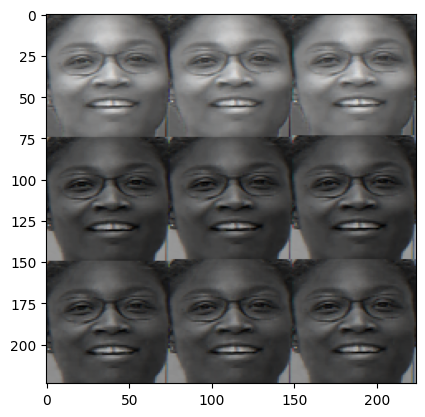

In [ ]:
from matplotlib import pyplot as plt

dataset = VideoFrameDataset(train_dir, preprocess=RetinaFacePreprocess())
dataset_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

for data, labels in dataset_loader:
    print(data.shape)
    print(labels.shape)
plt.imshow(data[0].reshape(224, 224, 3))


In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## 4. 모델 로드 및 수정

In [ ]:
import torch
from torchsummary import summary
from efficientnet_pytorch import EfficientNet

import torch.nn as nn

#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)  # 2개의 클래스 예시, Why? efficientnet_b7?, num_classes=2?
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=1)  # 2개의 클래스 예시, Why? efficientnet_b7?, num_classes=2?

# freeze feature extractor
#for param in model.parameters():
#    param.requires_grad = False
#del model._fc
#model._fc = nn.Linear(2560, 1)

summary(model, input_size=(3,224,224), device='cpu')


#model = torch.nn.parallel.DistributedDataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:07<00:00, 35.1MB/s]


Loaded pretrained weights for efficientnet-b7
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 64, 112, 112]           1,728
       BatchNorm2d-3         [-1, 64, 112, 112]             128
MemoryEfficientSwish-4         [-1, 64, 112, 112]               0
         ZeroPad2d-5         [-1, 64, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 64, 112, 112]             576
       BatchNorm2d-7         [-1, 64, 112, 112]             128
MemoryEfficientSwish-8         [-1, 64, 112, 112]               0
          Identity-9             [-1, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [-1, 16, 1, 1]               0
         Identity-12             [-1, 16, 1, 1]               0
Conv2dStaticSamePadding-13        

## 5. 손실 함수 및 옵티마이저 설정

In [ ]:
import torch.nn as nn
import torch.optim as optim

# BCE loss는 최종출력이 1개이고 sigmoid 사용
# 최종출력이 2개이면 cross entropy를 사용(cross entropy 내부적으로 softmax 적용함)
# Focal loss가 필요할지 재검토 필요
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

#criterion = FocalLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## 6. 학습 및 검증 루프 정의

In [ ]:
import numpy as np

# mixup이 필요할지 재검토 필요
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, dataloader, criterion, optimizer, device, log_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # label shape 확인할 것 (batchsize, 2)여야 함
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
#        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels) # mixup, alpha 값은?
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.unsqueeze(1)
        labels = labels.float()
#        loss = criterion(outputs, labels
#        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # mixup
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0

        running_loss += loss.item() * inputs.size(0)
#        _, preds = torch.max(outputs, 1)
#        preds = preds.unsqueeze(1)
#        preds = preds.float()
#        correct += (preds == labels).sum().item()
#        total += labels.size(0)

        correct += outputs.eq(labels).int().sum()

#    return running_loss / total, correct / total
    return running_loss / len(dataloader), 100*correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            loss = criterion(outputs, labels)

            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
#            print(preds)
#            print(labels)
#            preds = preds.unsqueeze(1)
#            preds = preds.float()
#            correct += (preds == labels).sum().item()
#            total += labels.size(0)

            correct += outputs.eq(labels).int().sum()

#    return running_loss / total, correct / total
    return running_loss / len(dataloader), 100*correct / len(dataloader.dataset)


## 7. 모델 학습

In [ ]:
import copy
import torch

# 모델 설정
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)  # 예시로 2개 클래스 설정, efficientnet-b7?, num_classes=2?
#model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=1)  # 예시로 2개 클래스 설정, efficientnet-b7?, num_classes=2?
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

# 학습 코드
num_epochs = 20
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
#    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
#    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#    if val_acc > best_val_acc:
#        best_val_acc = val_acc
#        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1/20
Train Loss: 8.6755, Train Acc: 14.0000
Epoch 2/20
Train Loss: 7.8815, Train Acc: 16.0000
Epoch 3/20
Train Loss: 7.4187, Train Acc: 26.0000
Epoch 4/20
Train Loss: 6.9458, Train Acc: 32.0000
Epoch 5/20
Train Loss: 6.4251, Train Acc: 34.0000
Epoch 6/20
Train Loss: 6.0630, Train Acc: 50.0000
Epoch 7/20
Train Loss: 5.4166, Train Acc: 62.0000
Epoch 8/20
Train Loss: 5.3275, Train Acc: 72.0000
Epoch 9/20
Train Loss: 4.7862, Train Acc: 72.0000
Epoch 10/20
Train Loss: 4.4278, Train Acc: 78.0000
Epoch 11/20
Train Loss: 4.2804, Train Acc: 76.0000
Epoch 12/20
Train Loss: 3.5187, Train Acc: 88.0000
Epoch 13/20
Train Loss: 2.9205, Train Acc: 94.0000
Epoch 14/20
Train Loss: 2.9185, Train Acc: 98.0000
Epoch 15/20
Train Loss: 2.6207, Train Acc: 92.0000
Epoch 16/20
Train Loss: 2.1919, Train Acc: 98.0000
Epoch 17/20
Train Loss: 1.8655, Train Acc: 100.0000
Epoch 18/20
Train Loss: 1.5349, Train Acc: 100.0000
Epoch 19/20
Train Loss: 1.9172, Train Acc: 96.0000
Epoch 20/20
Train Loss: 1.7441, Train 